<a href="https://colab.research.google.com/github/FiorenSt/SiSAD/blob/main/Tutorial_StampAD_LATENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STAMP AD Project - LATENT SPACE

## The goal is to build a network for unsupervised (or semi-supervised) clustering and detection of anomalies and transients in ZTF stamps.
### Here, we assume a network has already been trained and we want to evaluate its latent space predictions...

## To get started:

Step 0.
Click the link to access the google drive folder containing the images: [link Drive](https://drive.google.com/drive/folders/1nnenrg4EnyxGy9WsAofwOOBRjlYfO_Ex?usp=sharing)

Step 1.
Right click on the folder. Under Organize, click Add Shortcut (Add it to your drive)

Step 2.
Mount your drive in Colab with the code below

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
h5_folder_path = '/content/drive/MyDrive/DATA_STAMP_AD'

In [4]:
import os

# Ensure the path is correct
assert os.path.exists(h5_folder_path), "The specified path does not exist. Please check the path to the shared folder."

# List the first few files in the directory
print("Contents of the folder:", os.listdir(h5_folder_path)[:5])

Contents of the folder: ['data_371.h5', 'data_372.h5', 'data_373.h5', 'data_374.h5', 'data_375.h5']


## Files description

Each h5 file contains 1024 triplets (new, reference, difference) and a list of features associated to these triplets. (rb_score, drb_score, fid, magpsf, sigmapsf, classtar, ra, dec, fwhm, aimage, bimage, elong, nbad, nneg, jd, ndethist, ncovhist, jdstarthist, jdendhist) To visualize some of the images, run the code below:

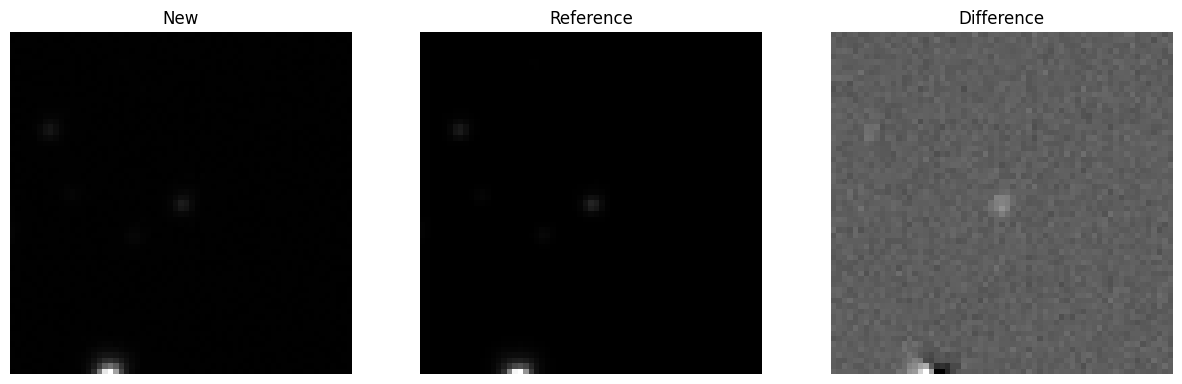

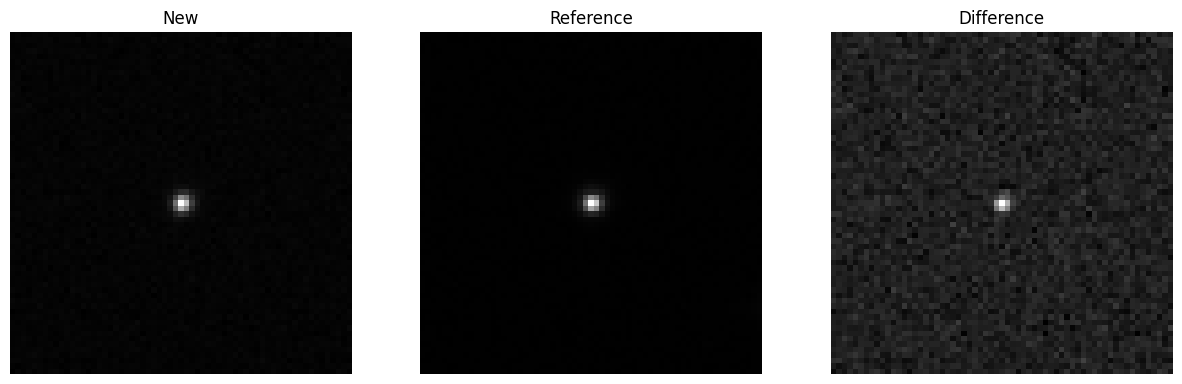

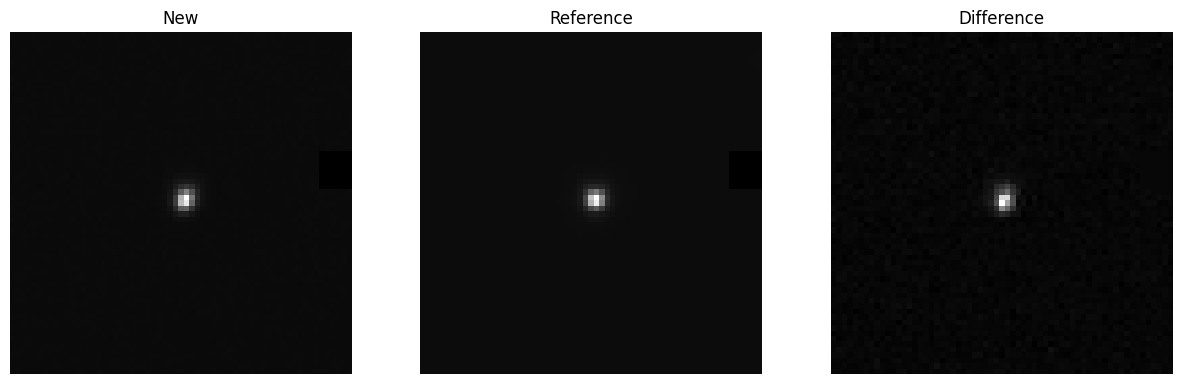

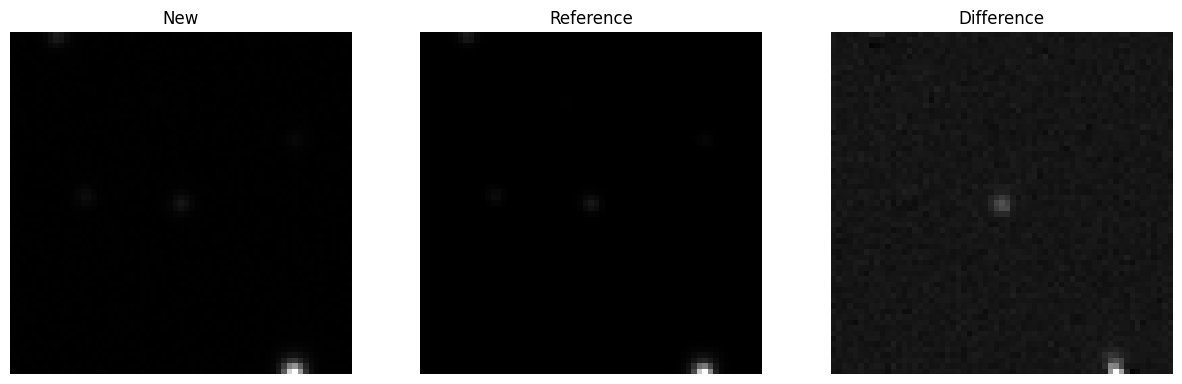

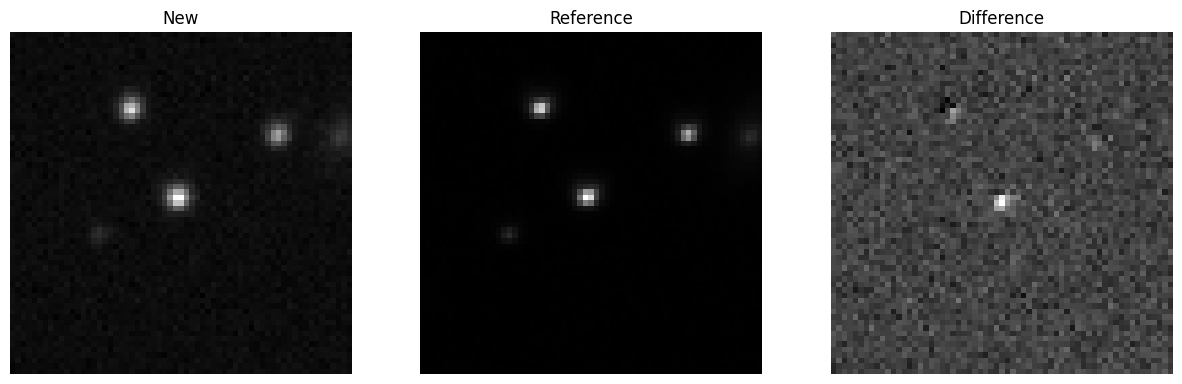

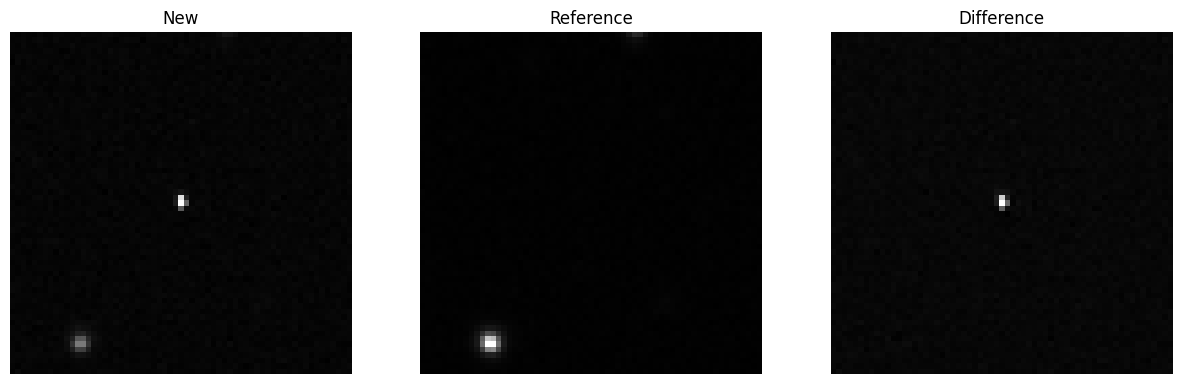

In [5]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# Function to plot a single triplet
def plot_triplet(triplet):
    """Plot a triplet of images."""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['New', 'Reference', 'Difference']
    for i, img in enumerate(triplet):
        axs[i].imshow(img, cmap='gray', origin='lower')
        axs[i].title.set_text(titles[i])
        axs[i].axis('off')
    plt.show()

# Example usage
all_image_paths = [str(path) for path in Path(h5_folder_path).glob('*.h5')]

# Choose a subset of files for demonstration
sample_paths = all_image_paths[:6]  # Adjust as needed

for file_path in sample_paths:
    with h5py.File(file_path, 'r') as hf:
        images = hf['images'][:]  # Assuming 'images' dataset shape is (N, 3, height, width)

        # Select and plot the first triplet from each file for demonstration
        img1, img2, diff_img = images[0]  # Extract the first triplet
        img1_nan_to_num = np.nan_to_num(img1, nan=0.0)
        img2_nan_to_num = np.nan_to_num(img2, nan=0.0)
        diff_img_nan_to_num = np.nan_to_num(diff_img, nan=0.0)

        plot_triplet([img1_nan_to_num, img2_nan_to_num, diff_img_nan_to_num])


# Example of preprocessing and simple network with Tensorflow

In [6]:
from skimage.exposure import rescale_intensity
import numpy as np
import h5py

def crop_center(img, cropx, cropy):
    """Crop the image in the center to the specified size."""
    y, x = img.shape  # Adjusted to expect 2D images
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]


def normalize_images(img1, img2):
    """Normalize first and second images together."""
    combined = np.stack([img1, img2])  # Combine images
    p2, p98 = np.percentile(combined, (2, 98))
    img1_rescaled = rescale_intensity(img1, in_range=(p2, p98))
    img2_rescaled = rescale_intensity(img2, in_range=(p2, p98))
    return img1_rescaled, img2_rescaled


def normalize_difference_based_on_range(diff_image, img1, img2):
    """Normalize the third image based on the range of the difference of the first two."""
    difference = img1 - img2
    diff_p2, diff_p98 = np.percentile(difference, (2, 98))
    diff_image_rescaled = rescale_intensity(diff_image, in_range=(diff_p2, diff_p98), out_range=(-1, 1))
    return diff_image_rescaled


def image_generator(image_paths, batch_size):
    """Yield batches of preprocessed input images, their corresponding output images, and labels."""
    for file_path in image_paths:
        with h5py.File(file_path, 'r') as hf:
            images = hf['images'][:]
            labels = hf['features'][:]

        # Process each triplet and its label in the file
        for start_idx in range(0, images.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, images.shape[0])
            batch_triplets = images[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            batch_inputs = []
            batch_outputs = []
            for idx, triplet in enumerate(batch_triplets):
                img1, img2, diff_img = [np.nan_to_num(img, nan=0.0) for img in triplet]
                img1_normalized, img2_normalized = normalize_images(img1, img2)
                diff_img_normalized = normalize_difference_based_on_range(diff_img, img1, img2)

                img1_cropped = crop_center(img1_normalized, 48, 48).reshape(48, 48, 1)
                img2_cropped = crop_center(img2_normalized, 48, 48).reshape(48, 48, 1)
                diff_img_cropped = crop_center(diff_img_normalized, 48, 48).reshape(48, 48, 1)

                input_images = np.concatenate([img1_cropped, img2_cropped], axis=-1)
                output_image = diff_img_cropped
                batch_inputs.append(input_images)
                batch_outputs.append(output_image)

            yield np.array(batch_inputs), np.array(batch_outputs), batch_labels


def get_test_with_features(image_paths, batch_size=1024):
    dataset = tf.data.Dataset.from_generator(
        lambda: image_generator(image_paths, batch_size),
        output_types=(tf.float32, tf.float32, tf.float32),  # Assuming generator yields inputs, outputs, and features
        output_shapes=([None, 48, 48, 2], [None, 48, 48, 1], [None, 19])
    )
    return dataset.map(lambda x, y, z: (x, z))  # Return inputs and features, ignore outputs




In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from pathlib import Path
import tensorflow as tf

# Load the full U-Net model
model_path = '/content/drive/MyDrive/DATA_STAMP_AD/MODELS/best_model.h5'
full_model = load_model(model_path)

from tensorflow.keras.layers import GlobalAveragePooling2D

pre_bottleneck_output = full_model.get_layer('bottleneck').output

# Attach the GAP layer to this output
gap_output = GlobalAveragePooling2D(name='gap_bottleneck')(pre_bottleneck_output)

# This model takes the original inputs but outputs the result of the GAP layer
bottleneck_model = Model(inputs=full_model.input, outputs=gap_output)


all_image_paths = [str(path) for path in Path('/content/drive/MyDrive/DATA_STAMP_AD/').glob('*.h5')]
test_dataset_with_features = get_test_with_features(all_image_paths, batch_size=1024)

# Assuming full_model is your model for prediction
predictions_list = []
features_list = []
for inputs, features in test_dataset_with_features:
    batch_predictions = bottleneck_model.predict(inputs)
    predictions_list.extend(batch_predictions)
    features_list.extend(features.numpy())  # Convert tensor to numpy if needed

# Convert lists to NumPy arrays
predictions = np.array(predictions_list)
features = np.array(features_list)

# Optionally, erase the original lists to free up memory
del predictions_list
del features_list


32/32 [==============================] - 0s 5ms/step


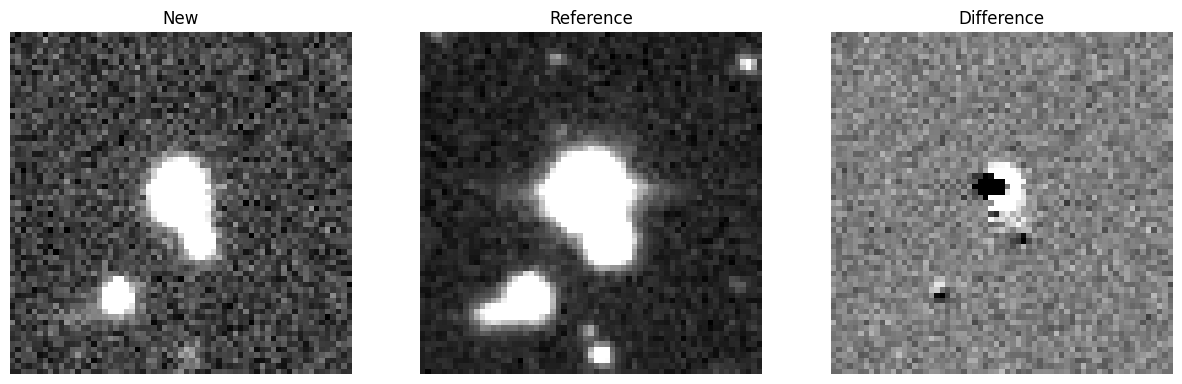

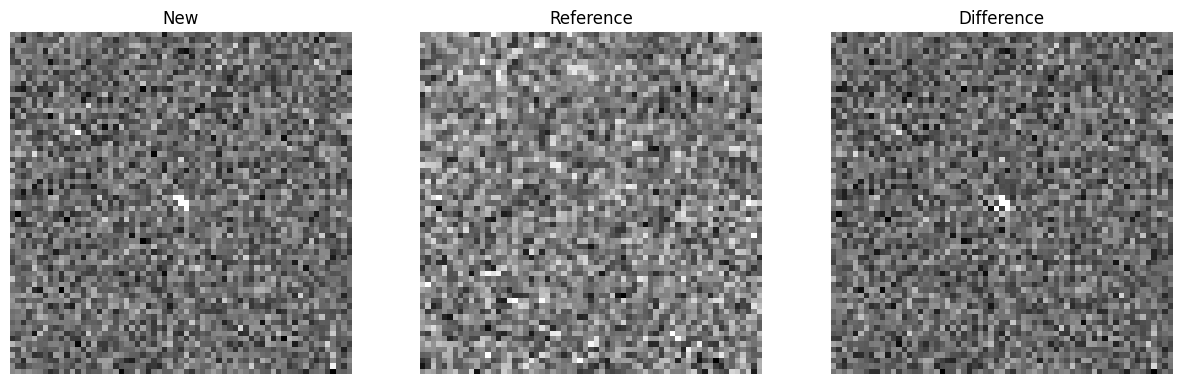

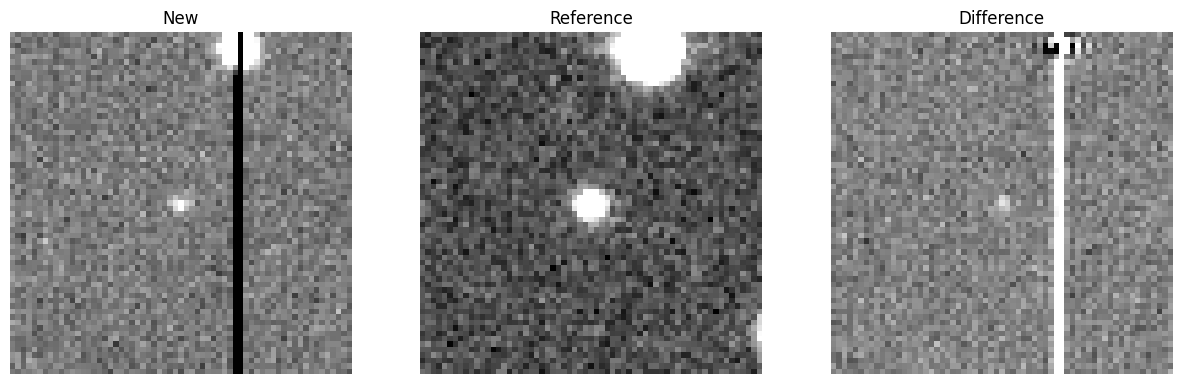

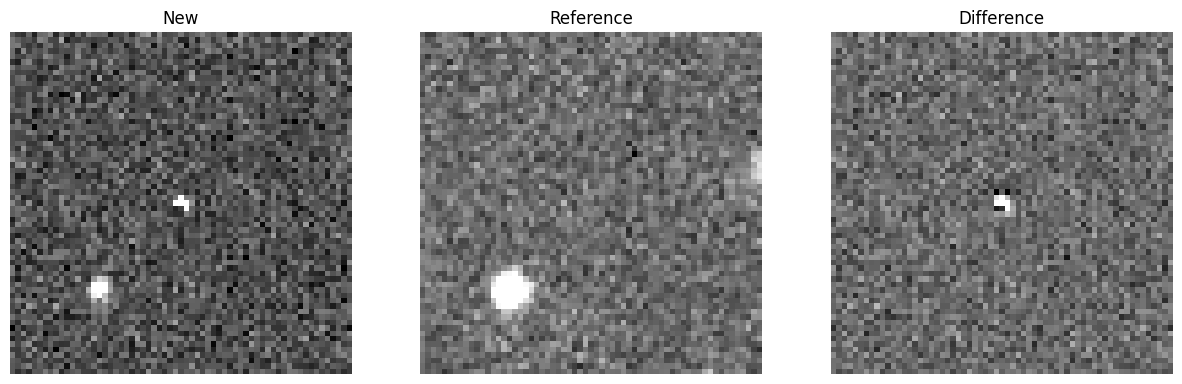

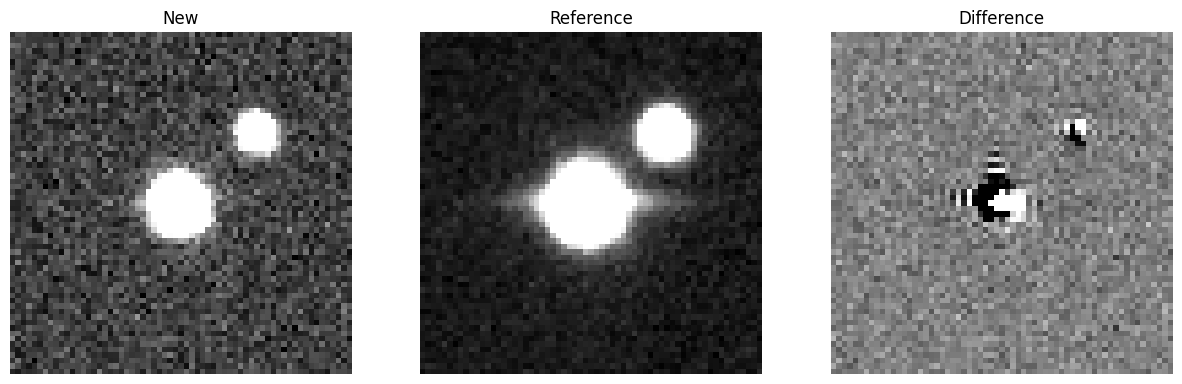

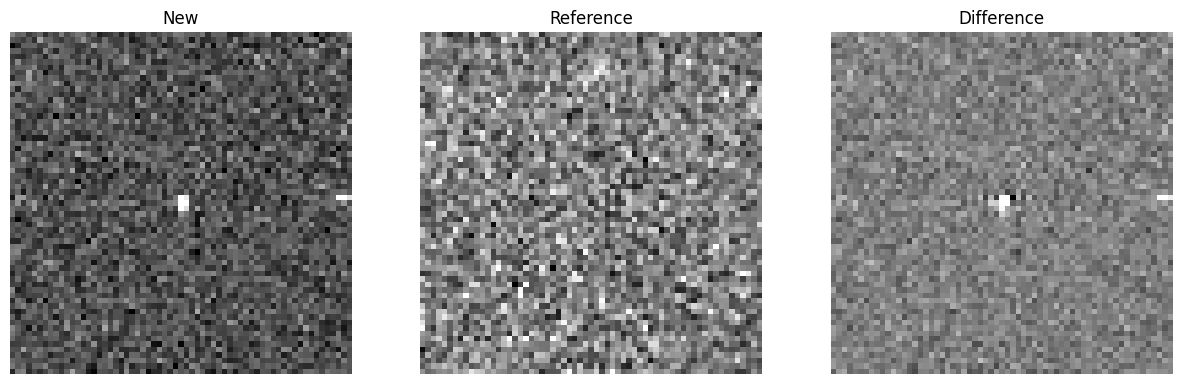

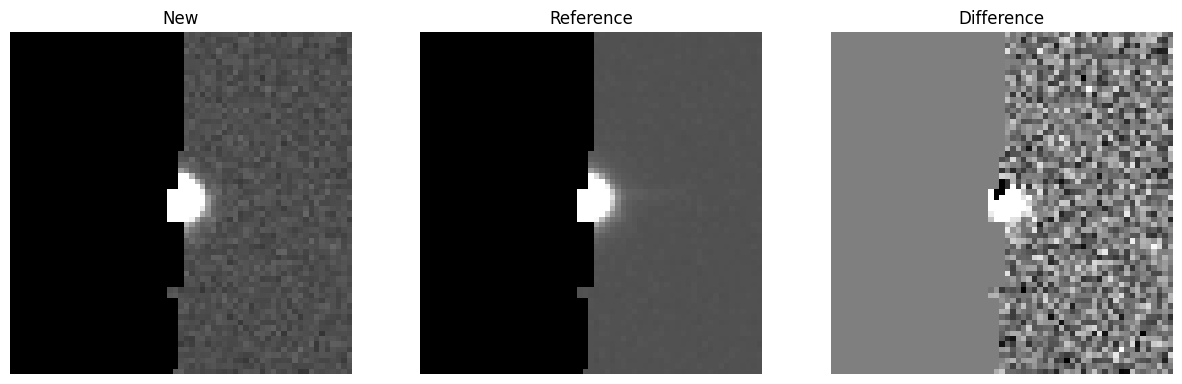

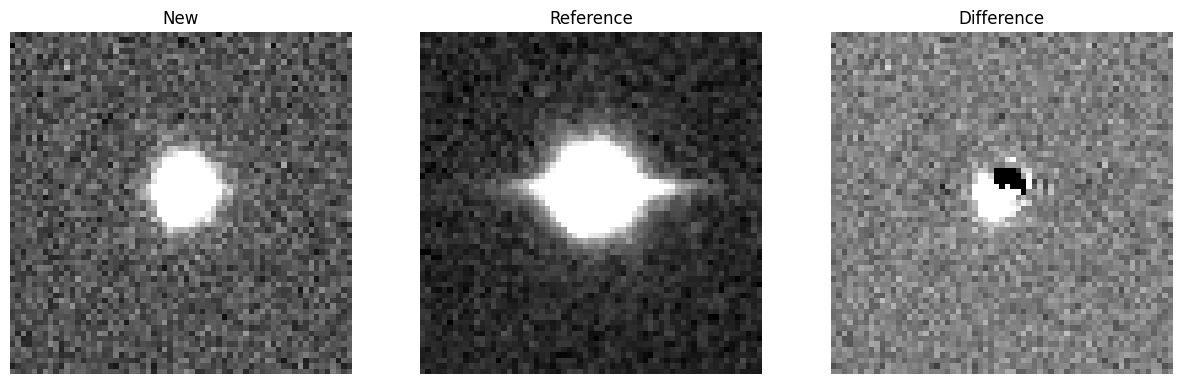

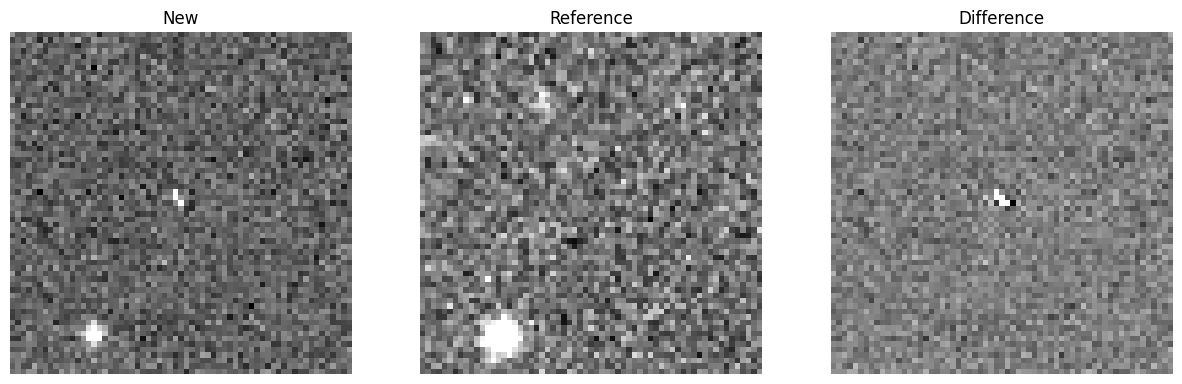

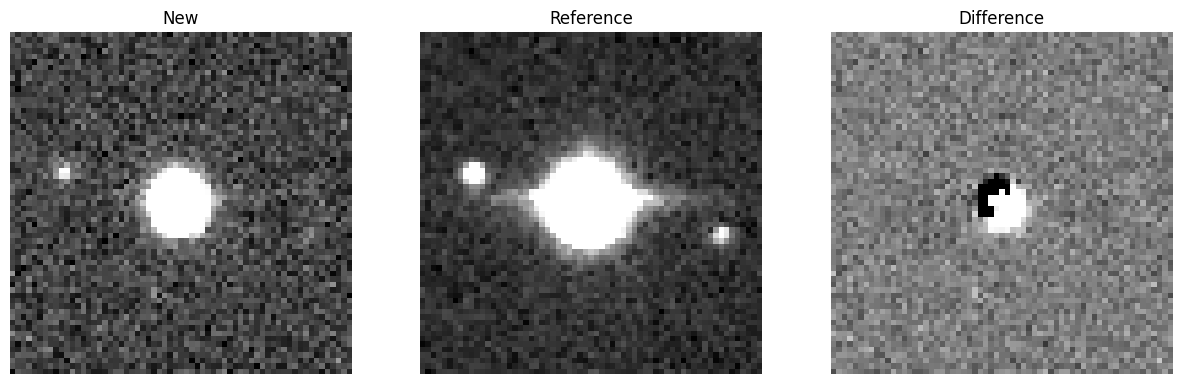

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import os

# Define the threshold for low DRB scores
DRB_THRESHOLD = 0.0001  # Adjust as necessary for "really low"

# Assume DRB score is at a specific index, e.g., index 0
drb_scores = features[:, 1]

# Identify indices of low DRB scores
low_drb_indices = np.where(drb_scores <= DRB_THRESHOLD)[0]


def plot_images_with_low_drb(low_drb_indices, image_paths, batch_size=1024, samples_to_plot=10):
    """
    Plots a subset of images associated with low DRB scores.
    """
    zscale = ZScaleInterval()

    plotted = 0

    for file_path in image_paths:
        with h5py.File(file_path, 'r') as hf:
            images = hf['images'][:]

        # Only proceed if the current file contains relevant images
        relevant_indices = [idx for idx in low_drb_indices if idx < images.shape[0]]
        if not relevant_indices:
            continue

        for idx in relevant_indices:
            if plotted >= samples_to_plot:
                break

            # Extract and preprocess images
            img1, img2, diff_img = images[idx]

            # Plot images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            for ax, img, title in zip(axs, [img1, img2, diff_img], ['New', 'Reference', 'Difference']):
                vmin, vmax = zscale.get_limits(img)
                ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
                ax.set_title(title)
                ax.axis('off')

            plt.show()
            plotted += 1


# Load and preprocess images from paths with low DRB scores
plot_images_with_low_drb(low_drb_indices, all_image_paths, samples_to_plot=10)


In [ ]:
!pip install umap-learn

In [9]:
### SUPERVISED CLASSIFICATION FROM LATENT SPACE  FOR REAL BOGUS and FEATURES IMPORTANCE

In [11]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.5 MB/s eta 0:00:00


Accuracy: 0.9098260604211169


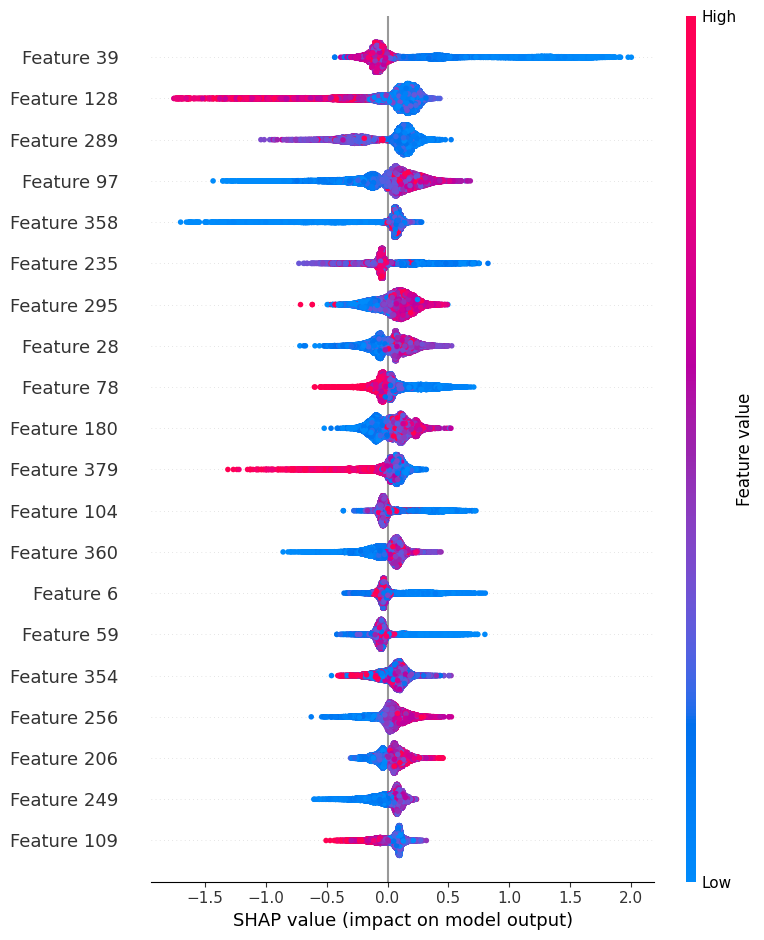

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming `features` contains your continuous R/B scores in the second column
rb_scores = features[:, 1]

# Discretize the R/B scores into binary labels
# Adjust the threshold as needed
threshold = 0.5
y = np.where(rb_scores > threshold, 1, 0)

from sklearn.preprocessing import StandardScaler

# Assuming X_latent is your latent space representations
scaler = StandardScaler()
X_latent_standardized = scaler.fit_transform(predictions)

# Assuming `X_latent` is your latent space representations and `y` are your labels
X_train, X_test, y_train, y_test = train_test_split(X_latent_standardized, y, test_size=0.2, random_state=42)

# Train the classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
classifier.fit(X_train, y_train)

# Evaluate the classifier
pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# SHAP values
explainer = shap.Explainer(classifier)
shap_values = explainer(X_train)

# Plot the summary
shap.summary_plot(shap_values, X_train)


Accuracy: 0.988556606652426


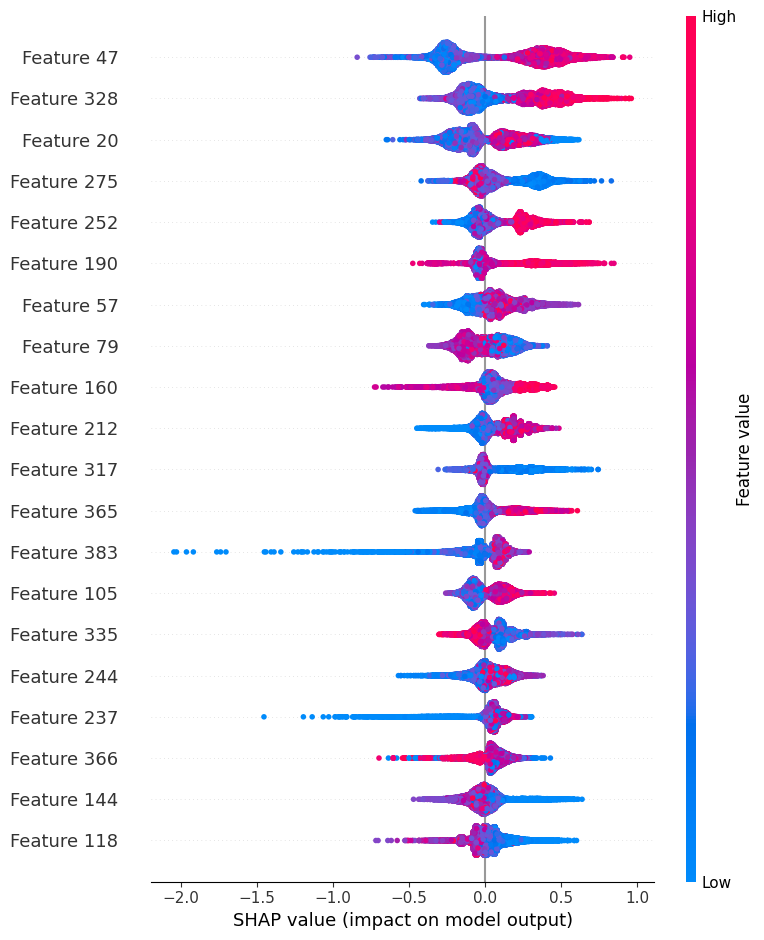

In [23]:
### SUPERVISED CLASSIFICATION FROM LATENT SPACE  FOR STAr/GALAXY and FEATURES IMPORTANCE

import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming `features` contains your continuous R/B scores in the second column
sg_scores = features[:, 5]


# Discretize the R/B scores into binary labels
# Adjust the threshold as needed
threshold = 0.5
y = np.where(sg_scores > threshold, 1, 0)

from sklearn.preprocessing import StandardScaler

# Assuming X_latent is your latent space representations
scaler = StandardScaler()
X_latent_standardized = scaler.fit_transform(predictions)

# Assuming `X_latent` is your latent space representations and `y` are your labels
X_train, X_test, y_train, y_test = train_test_split(X_latent_standardized, y, test_size=0.2, random_state=42)

# Train the classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
classifier.fit(X_train, y_train)

# Evaluate the classifier
pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# SHAP values
explainer = shap.Explainer(classifier)
shap_values_2 = explainer(X_train)

# Plot the summary
shap.summary_plot(shap_values_2, X_train)


(array([2.5950e+03, 2.2100e+02, 1.6100e+02, 9.6000e+01, 7.3000e+01,
        7.7000e+01, 6.6000e+01, 4.6000e+01, 4.8000e+01, 3.4000e+01,
        4.0000e+01, 4.4000e+01, 4.1000e+01, 3.3000e+01, 3.9000e+01,
        3.7000e+01, 2.7000e+01, 3.8000e+01, 3.2000e+01, 3.2000e+01,
        1.3000e+01, 2.5000e+01, 2.9000e+01, 2.7000e+01, 2.4000e+01,
        2.4000e+01, 2.1000e+01, 3.5000e+01, 2.5000e+01, 2.5000e+01,
        2.3000e+01, 2.5000e+01, 2.4000e+01, 2.6000e+01, 2.5000e+01,
        2.7000e+01, 1.6000e+01, 2.5000e+01, 3.0000e+01, 2.8000e+01,
        2.0000e+01, 3.1000e+01, 1.7000e+01, 2.3000e+01, 2.5000e+01,
        3.4000e+01, 1.9000e+01, 3.1000e+01, 2.4000e+01, 2.0000e+01,
        2.9000e+01, 2.4000e+01, 2.6000e+01, 1.7000e+01, 3.0000e+01,
        2.8000e+01, 2.5000e+01, 2.4000e+01, 3.2000e+01, 3.3000e+01,
        3.7000e+01, 3.3000e+01, 2.2000e+01, 2.6000e+01, 3.6000e+01,
        4.2000e+01, 2.4000e+01, 3.6000e+01, 3.6000e+01, 3.6000e+01,
        3.5000e+01, 4.1000e+01, 4.9000e+01, 3.50

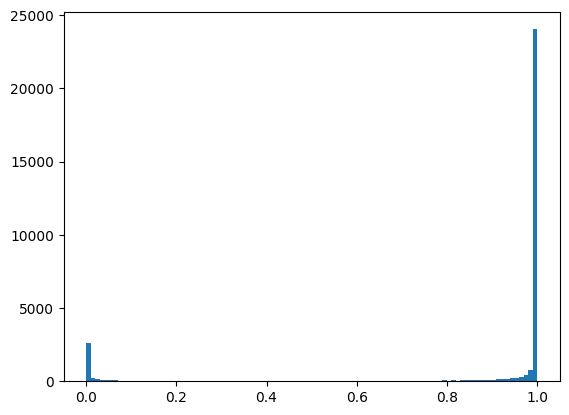

In [26]:
plt.hist(rb_scores, bins=100)

In [18]:
### COMBINE BINARY CLASSIFIERS IMPORTANCES

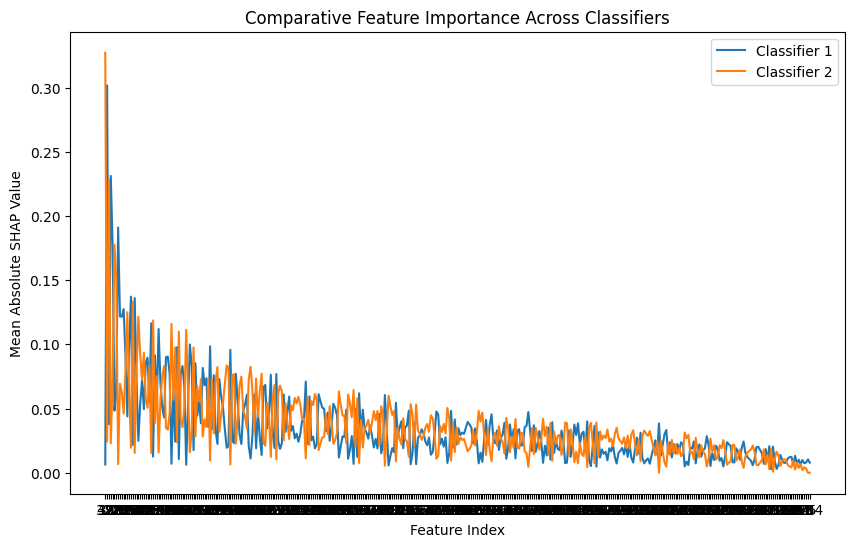

In [27]:
import matplotlib.pyplot as plt

# Placeholder for aggregated SHAP values for each classifier
# Assuming `shap_values_1`, `shap_values_2`, `shap_values_3` are the SHAP values from your 3 classifiers
# Each of these is expected to be an array of SHAP values with the same shape as `X_train`
aggregated_shap_values = [np.abs(shap_values.values).mean(axis=0),
                          np.abs(shap_values_2.values).mean(axis=0),
                         ]

# Taking the mean across classifiers for each feature
mean_shap_values = np.mean(aggregated_shap_values, axis=0)

# Sorting features by their mean importance
sorted_indices = np.argsort(mean_shap_values)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
for i, shap_values in enumerate(aggregated_shap_values):
    plt.plot(np.arange(len(shap_values)), shap_values[sorted_indices], label=f'Classifier {i+1}')

plt.legend()
plt.xlabel('Feature Index')
plt.ylabel('Mean Absolute SHAP Value')
plt.title('Comparative Feature Importance Across Classifiers')
plt.xticks(np.arange(len(shap_values)), labels=sorted_indices)
plt.show()
